<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Causal-model" data-toc-modified-id="Causal-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Causal model</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Data-sets" data-toc-modified-id="Data-sets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data sets</a></span><ul class="toc-item"><li><span><a href="#Synthetic-data-with-unobservables" data-toc-modified-id="Synthetic-data-with-unobservables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Synthetic data with unobservables</a></span></li><li><span><a href="#Data-without-unobservables" data-toc-modified-id="Data-without-unobservables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data without unobservables</a></span></li></ul></li><li><span><a href="#Algorithms" data-toc-modified-id="Algorithms-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Algorithms</a></span><ul class="toc-item"><li><span><a href="#Contraction-algorithm" data-toc-modified-id="Contraction-algorithm-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Contraction algorithm</a></span></li><li><span><a href="#Causal-algorithm" data-toc-modified-id="Causal-algorithm-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Causal algorithm</a></span></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Performance comparison</a></span><ul class="toc-item"><li><span><a href="#With-unobservables-in-the-data" data-toc-modified-id="With-unobservables-in-the-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>With unobservables in the data</a></span><ul class="toc-item"><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Predictive models</a></span></li><li><span><a href="#Visual-comparison" data-toc-modified-id="Visual-comparison-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Visual comparison</a></span></li></ul></li><li><span><a href="#Without-unobservables" data-toc-modified-id="Without-unobservables-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Without unobservables</a></span><ul class="toc-item"><li><span><a href="#Predictive-model" data-toc-modified-id="Predictive-model-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Predictive model</a></span></li></ul></li></ul></li></ul></div>

##  Causal model

Our model is defined by the probabilistic expression 

\begin{equation} \label{model_disc}
P(Y=0 | \text{do}(R=r)) = \sum_x \underbrace{P(Y=0|X=x, T=1)}_\text{1} 
\overbrace{P(T=1|R=r, X=x)}^\text{2} 
\underbrace{P(X=x)}_\text{3}
\end{equation}

which is equal to 

\begin{equation}\label{model_cont}
P(Y=0 | \text{do}(R=r)) = \int_x P(Y=0|X=x, T=1)P(T=1|R=r, X=x)P(X=x)
\end{equation}

for continuous $x$. Model as a graph (Z is a latent variable, and can be excluded from the expression with do-calculus by showing that $X$ is admissible for adjustment):

![Model as picture](../figures/intervention_model.png "Intervention model")

For predicting the probability of negative outcome the following should hold because by Pearl $P(Y=0 | \text{do}(R=r), X=x) = P(Y=0 | R=r, X=x)$ when $X$ is an admissible set:

\begin{equation} \label{model_pred}
P(Y=0 | \text{do}(R=r), X=x) = P(Y=0|X=x, T=1)P(T=1|R=r, X=x).
\end{equation}

Still it should be noted that this prediction takes into account the probability of the individual to be given a positive decision ($T=1$), see second term in \ref{model_pred}.

----

### Notes

* Equations \ref{model_disc} and \ref{model_cont} describe the whole causal effect in the population (the causal effect of changing $r$ over all strata $X$).
* Prediction should be possible with \ref{model_pred}. Both terms can be learned from the data. NB: the probability $P(Y=0 | \text{do}(R=r), X=x)$ is lowest when the individual $x$ is the most dangerous or the least dangerous. How could we infer/predict the counterfactual "what is the probability of $Y=0$ if we were to let this individual go?" has yet to be calculated.
* Is the effect of R learned/estimated correctly if it is just plugged in to a predictive model (e.g. logistic regression)?
* $P(Y=0 | do(R=0)) = 0$ only in this application. My predictive models say that when $r=0$ the probability $P(Y=0) \approx 0.027$ which would be a natural estimate in another application/scenario (e.g. in medicine the probability of an adverse event when a stronger medicine is distributed to everyone. Then the probability will be close to zero but not exactly zero.)

In [97]:
# Imports

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.integrate as si
import seaborn as sns
import numpy.random as npr
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Settings

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (14, 7)})

# Suppress deprecation warnings.

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data sets

### Synthetic data with unobservables

In the chunk below, we generate the synthetic data as described by Lakkaraju et al. The default values and definitions of $Y$ and $T$ values follow their description.

**Parameters**

* M = `nJudges_M`, number of judges
* N = `nSubjects_N`, number of subjects assigned to each judge
* betas $\beta_i$ = `beta_i`, where $i \in \{X, Z, W\}$ are coefficients for the respected variables

**Columns of the data:**

* `judgeID_J` = judge IDs as running numbering from 0 to `nJudges_M - 1`
* R = `acceptanceRate_R`, acceptance rates
* X = `X`, invidual's features observable to all (models and judges)
* Z = `Z`, information observable for judges only
* W = `W`, unobservable / inaccessible information
* T = `decision_T`, bail-or-jail decisions where $T=0$ represents jail decision and $T=1$ bail decision.
* Y = `result_Y`, result variable, if $Y=0$ person will or would recidivate and if $Y=1$ person will or would not commit a crime.

In [98]:
# Set seed for reproducibility
#npr.seed(0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generateData(nJudges_M=100,
                 nSubjects_N=500,
                 beta_X=1.0,
                 beta_Z=1.0,
                 beta_W=0.2):

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    judgeID_J = np.repeat(np.arange(0, nJudges_M, dtype=np.int32), nSubjects_N)

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    acceptanceRate_R = np.repeat(acceptance_rates, nSubjects_N)

    # Sample the variables from standard Gaussian distributions.
    X = npr.normal(size=nJudges_M * nSubjects_N)
    Z = npr.normal(size=nJudges_M * nSubjects_N)
    W = npr.normal(size=nJudges_M * nSubjects_N)

    probabilities_Y = sigmoid(beta_X * X + beta_Z * Z + beta_W * W)

    # 0 if P(Y = 0| X = x; Z = z; W = w) >= 0.5 , 1 otherwise
    result_Y = 1 - probabilities_Y.round()
    
    # For the conditional probabilities of T we add noise ~ N(0, 0.1)
    probabilities_T = sigmoid(beta_X * X + beta_Z * Z)
    probabilities_T += npr.normal(0, np.sqrt(0.1), nJudges_M * nSubjects_N)

    # Initialize decision values as 1
    decision_T = np.ones(nJudges_M * nSubjects_N)

    # Initialize the dataframe
    df_init = pd.DataFrame(np.column_stack(
        (judgeID_J, acceptanceRate_R, X, Z, W, result_Y, probabilities_T,
         decision_T)),
                           columns=[
                               "judgeID_J", "acceptanceRate_R", "X", "Z", "W",
                               "result_Y", "probabilities_T", "decision_T"
                           ])

    # Sort by judges then probabilities in decreasing order
    data = df_init.sort_values(by=["judgeID_J", "probabilities_T"],
                               ascending=False)

    # Iterate over the data. Subject is in the top (1-r)*100% if
    # his within-judge-index is over acceptance threshold times
    # the number of subjects assigned to each judge. If subject
    # is over the limit they are assigned a zero, else one.
    data.reset_index(drop=True, inplace=True)

    data['decision_T'] = np.where(
        (data.index.values % nSubjects_N) <
        ((1 - data['acceptanceRate_R']) * nSubjects_N), 0, 1)

    return data


df = generateData()

pd.crosstab(df.decision_T, df.result_Y, margins=True)

result_Y      0.0    1.0    All
decision_T                     
0           16267   6842  23109
1            8765  18126  26891
All         25032  24968  50000

In [99]:
# Split the data set to test and train
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.5, random_state=0)

print(train.shape)
print(test.shape)

train_labeled = train.copy()
test_labeled = test.copy()

# Set results as NA if decision is negative.
train_labeled.result_Y = np.where(train.decision_T == 0, np.nan, train.result_Y)
test_labeled.result_Y = np.where(test.decision_T == 0, np.nan, test.result_Y)

print(train_labeled.shape)
print(test_labeled.shape)

tab = train_labeled.groupby(['result_Y', 'decision_T']).size()
tab.unstack()

(25000, 8)
(25000, 8)
(25000, 8)
(25000, 8)


decision_T     1
result_Y        
0.0         4317
1.0         9047

### Data without unobservables

In the chunk below, we generate a simplified data. The default values and definitions of $Y$ and $T$ values follow the previous description.

**Parameters**

* M = `nJudges_M`, number of judges
* N = `nSubjects_N`, number of subjects assigned to each judge
* betas $\beta_i$ = `beta_i`, where $i \in \{X, Z, W\}$ are coefficients for the respected variables

**Columns of the data:**

* `judgeID_J` = judge IDs as running numbering from 0 to `nJudges_M - 1`
* R = `acceptanceRate_R`, acceptance rates
* X = `X`, invidual's features observable to all (models and judges), now $X \sim \mathcal{N}(0, 1)$
* T = `decision_T`, bail-or-jail decisions where $T=0$ represents jail decision and $T=1$ bail decision.
* $p_y$ = `probabilities_Y`, variable where $p_y = P(Y=1)$
* Y = `result_Y`, result variable, if $Y=0$ person will or would recidivate and if $Y=1$ person will or would not commit a crime. Here $Y \sim \text{Bernoulli}(1/exp(\beta_X \cdot X))$

In [100]:
# Set seed for reproducibility
#npr.seed(0)

def generateDataNoUnobservables(nJudges_M=100, nSubjects_N=500, beta_X=1.0):

    df = pd.DataFrame()

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(np.arange(0, nJudges_M, dtype=np.int32),
                                       nSubjects_N))

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    # Sample the variables from standard Gaussian distributions.
    df = df.assign(X=npr.normal(size=nJudges_M * nSubjects_N))

    df = df.assign(probabilities_Y=sigmoid(beta_X * df.X))

    # Y ~ Bernoulli(sigmoid(beta_X * x))
    df = df.assign(result_Y=npr.binomial(
        n=1, p=df.probabilities_Y, size=nJudges_M * nSubjects_N))

    # Sort by judges then probabilities in decreasing order.
    # I.e. most dangerous are last.
    df = df.sort_values(by=["judgeID_J", "probabilities_Y"], ascending=True)

    # Iterate over the data. Subject is in the top (1-r)*100% if
    # his within-judge-index is over acceptance threshold times
    # the number of subjects assigned to each judge. If subject
    # is over the limit they are assigned a zero, else one.
    df.reset_index(drop=True, inplace=True)

    df['decision_T'] = np.where((df.index.values % nSubjects_N) <
                                ((1 - df['acceptanceRate_R']) * nSubjects_N),
                                0, 1)

    return df

simple_data = generateDataNoUnobservables()

# Split the data set to test and train
s_train, s_test = train_test_split(simple_data, test_size=0.5, random_state=0)

s_train_labeled = s_train.copy()
s_test_labeled = s_test.copy()

# Set results as NA if decision is negative.
s_train_labeled.result_Y = np.where(s_train.decision_T == 0, np.nan, s_train.result_Y)
s_test_labeled.result_Y = np.where(s_test.decision_T == 0, np.nan, s_test.result_Y)

#display(simple_data.head(20))

print(simple_data.columns.values)

display(pd.crosstab(simple_data.decision_T, simple_data.result_Y,
                    margins=True))

display(pd.crosstab(s_train.decision_T, s_train.result_Y,
                    margins=True))

display(pd.crosstab(s_test.decision_T, s_test.result_Y,
                    margins=True))

['judgeID_J' 'acceptanceRate_R' 'X' 'probabilities_Y' 'result_Y'
 'decision_T']


result_Y        0      1    All
decision_T                     
0           15791   8833  24624
1            9157  16219  25376
All         24948  25052  50000

result_Y        0      1    All
decision_T                     
0            7960   4327  12287
1            4634   8079  12713
All         12594  12406  25000

result_Y        0      1    All
decision_T                     
0            7831   4506  12337
1            4523   8140  12663
All         12354  12646  25000

## Algorithms

### Contraction algorithm

Below is an implementation of Lakkaraju's team's algorithm presented in [their paper](https://helka.finna.fi/PrimoRecord/pci.acm3098066). Relevant parameters to be passed to the function are presented in the description.

In [101]:
def contraction(df,
                judgeIDJ_col,
                decisionT_col,
                resultY_col,
                modelProbS_col,
                accRateR_col,
                r):
    '''
    This is an implementation of the algorithm presented by Lakkaraju
    et al. in their paper "The Selective Labels Problem: Evaluating 
    Algorithmic Predictions in the Presence of Unobservables" (2017).
    
    Parameters:
    df = The (Pandas) data frame containing the data, judge decisions,
    judge IDs, results and probability scores.
    judgeIDJ_col = String, the name of the column containing the judges' IDs
    in df.
    decisionT_col = String, the name of the column containing the judges' decisions
    resultY_col = String, the name of the column containing the realization
    modelProbS_col = String, the name of the column containing the probability
    scores from the black-box model B.
    accRateR_col = String, the name of the column containing the judges' 
    acceptance rates
    r = Float between 0 and 1, the given acceptance rate.
    
    Returns:
    u = The estimated failure rate at acceptance rate r.
    '''
    # Get ID of the most lenient judge.
    most_lenient_ID = df[judgeIDJ_col].loc[df[accRateR_col].idxmax()]

    # Subset
    D_q = df[df[judgeIDJ_col] == most_lenient_ID].copy()

    # All observations of R_q have observed outcome labels
    R_q = D_q[D_q[decisionT_col] == 1]

    # "Observations deemed as high risk by B are at the top of this list"
    R_sort_q = R_q.sort_values(by=modelProbS_col, ascending=False)

    number_to_remove = int(
        round((1.0 - r) * D_q.shape[0] - (D_q.shape[0] - R_q.shape[0])))

    # "R_B is the list of observations assigned to t = 1 by B"
    R_B = R_sort_q[number_to_remove:R_sort_q.shape[0]]

    return np.sum(R_B[resultY_col] == 0) / D_q.shape[0]

### Causal algorithm

Generalized performance:

$$
\mathbf{gp} = \sum_x f(x)\delta(F(x) < r)P(X=x)
$$

and empirical performance:

$$
\mathbf{ep} = \dfrac{1}{n} \sum_{(x, y) \in \mathcal{D}} \delta(y=0) \delta(F(x) < r)
$$

where

$$
F(x_0) = \int P(x)~\delta(P(Y=0|T=1, X=x) > P(Y=0|T=1, X=x_0)) ~ dx
$$

and

$$
f(x) = P(Y=0|T=1, X=x).
$$

In [102]:
def getProbabilityForClass(x, model, class_value):
    '''
    Function (wrapper) for obtaining the probability of a class given x and a 
    predictive model.
    
    Parameters:
    x = individual features, an array, shape (observations, features)
    model = a trained sklearn model. Predicts probabilities for given x. Should
    accept input of size (observations, features)
    class_value = the resulting class to predict (usually 0 or 1).
    
    Returns:
    The probabilities of given class label for each x.
    '''
    if x.ndim == 1:
        # if x is vector, transform to column matrix.
        f_values = model.predict_proba(np.array(x).reshape(-1, 1))
    else:
        f_values = model.predict_proba(x)

    # Get correct column of predicted class, remove extra dimensions and return.
    return f_values[:, model.classes_ == class_value].flatten()

def cdf(x_0, model, class_value):
    '''
    Cumulative distribution function as described above.
    
    '''
    prediction = lambda x: getProbabilityForClass(np.array([x]).reshape(-1,1), model, class_value)
    
    prediction_x_0 = prediction(x_0)
    
    results = np.zeros(x_0.shape[0])
    
    x_values = np.linspace(-10, 10, 50000)
    
    for i in range(x_0.shape[0]):
        results[i] = si.simps(scs.norm.pdf(x_values) * (prediction(x_values) > prediction_x_0[i]), x=x_values)
    
    return results

#%timeit cdf(np.ones(1), logreg, 0)
#%timeit cdf(np.ones(10), logreg, 0)
#%timeit cdf(np.ones(100), logreg, 0)
#
#x_values = np.linspace(-10, 10, 1000)
#
#print(getProbabilityForClass(s_train.X.head(1), logreg, 0))
#
#plt.plot(x_values, getProbabilityForClass(x_values, logreg, 0))
#plt.show()

## Performance comparison

Below we try to replicate the results obtained by Lakkaraju and compare their model's performance to the one of ours.

### With unobservables in the data

#### Predictive models

Lakkaraju says that they used logistic regression. We train the predictive models using only *observed observations*, i.e. observations for which labels are available. We then predict the probability of negative outcome for all observations in the test data and attach it to our data set.

In [103]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
logreg = logreg.fit(
    train_labeled.X[train_labeled.decision_T == 1].values.reshape(-1, 1),
    train_labeled.result_Y[train_labeled.decision_T == 1])

# predict probabilities and attach to data
label_probs_logreg = logreg.predict_proba(test.X.values.reshape(-1, 1))

test = test.assign(B_prob_0_logreg=label_probs_logreg[:, 0])
test_labeled = test_labeled.assign(B_prob_0_logreg=label_probs_logreg[:, 0])

We train another logistic regression model for predicting the probability of positive decision with a given leniency r  and individual features x. See part 2 of eq. 1.

In [104]:
# Instantiate the model (using the default parameters)
decision_model = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
decision_model = decision_model.fit(train[['X', 'acceptanceRate_R']],
                                    train.decision_T)

#### Visual comparison

Let's plot the failure rates against the acceptance rates using the difference. For the causal model we plot $P(Y=0|do(R=r))$ against r.

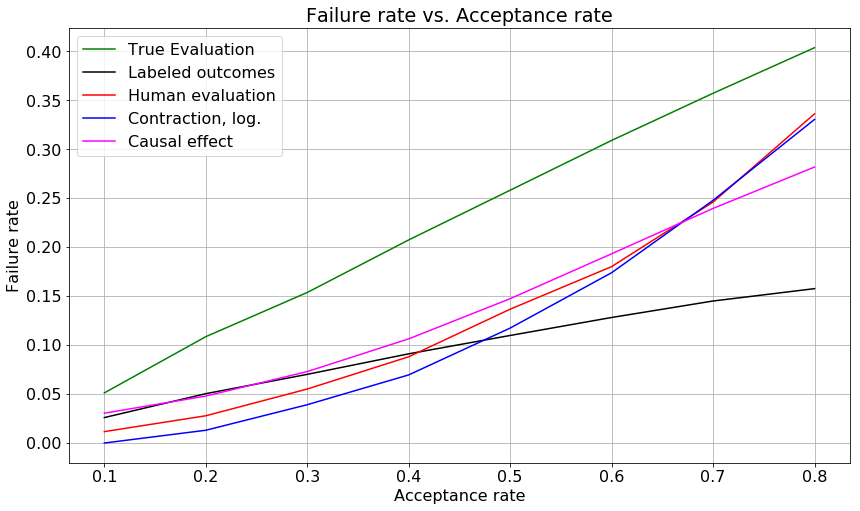

In [105]:
failure_rates = np.zeros((8, 5))

for r in np.arange(1, 9):
    
    #### True evaluation
    # Sort by failure probabilities, subjects with the smallest risk are first. 
    test.sort_values(by='B_prob_0_logreg', inplace=True, ascending=True)

    to_release = int(round(test.shape[0] * r / 10))

    # Calculate failure rate as the ratio of failures to successes among those 
    # who were given a positive decision, i.e. those whose probability of negative
    # outcome was low enough.
    failure_rates[r - 1, 0] = np.mean(test.result_Y[0:to_release] == 0)
    
    #### Labeled outcomes only
    # Sort by failure probabilities, subjects with the smallest risk are first. 
    test_labeled.sort_values(by='B_prob_0_logreg', inplace=True, ascending=True)
        
    to_release = int(round(test_labeled.shape[0] * r / 10))

    failure_rates[r - 1, 1] = np.mean(test_labeled.result_Y[0:to_release] == 0)
    
    #### Human error rate
    # Get judges with correct leniency as list
    correct_leniency_list = test_labeled.judgeID_J[
        test_labeled['acceptanceRate_R'].round(1) == r / 10].values

    # Released are the people they judged and released, T = 1
    released = test_labeled[test_labeled.judgeID_J.isin(correct_leniency_list)
                            & (test_labeled.decision_T == 1)]

    # Get their failure rate, aka ratio of reoffenders to number of people judged in total
    failure_rates[r - 1, 2] = np.sum(
        released.result_Y == 0) / correct_leniency_list.shape[0]
    
    #### Contraction, logistic regression
    failure_rates[r - 1, 3] = contraction(
        test_labeled, 'judgeID_J', 'decision_T', 'result_Y', 'B_prob_0_logreg',
        'acceptanceRate_R', r / 10)

    #### Causal effect - "vanilla" (wrong) model
    # Integral of P(Y=0 | T=1, X=x)*P(T=1 | R=r, X=x)*P(X=x) from negative to
    # positive infinity.
    failure_rates[r - 1, 4] = si.quad(lambda x: getProbabilityForClass(np.array([x]), logreg, 0) * 
                                      getProbabilityForClass(np.array([[x, r/10]]), decision_model, 1) * 
                                      scs.norm.pdf(x), -np.inf, np.inf)[0]

# Error bars TBA

plt.figure(figsize=(14, 8))
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 0], label='True Evaluation', c='green')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 1], label='Labeled outcomes', c='black')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 2], label='Human evaluation', c='red')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 3], label='Contraction, log.', c='blue')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 4], label='Causal effect', c='magenta')

plt.title('Failure rate vs. Acceptance rate')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

In [106]:
# Below are estimates for P(Y=0 | do(R=0)) and P(Y=0 | do(R=1))
#r = 0.0
#print(r, si.quad(lambda x: f(np.array([[x, r]]), decision_model, 1) * \
#                 f(np.array([x]), logreg, 0) * scs.norm.pdf(x), -np.inf, np.inf))
#
#r = 1.0
#print(r, si.quad(lambda x: f(np.array([[x, r]]), decision_model, 1) * \
#                 f(np.array([x]), logreg, 0) * scs.norm.pdf(x), -np.inf, np.inf))

So it can be concluded that:

\begin{equation*}
P(Y=0 | \text{do}(R=0)) \approx 0.018 \\
P(Y=0 | \text{do}(R=1)) \approx 0.340 \\
\end{equation*}

### Without unobservables


#### Predictive model


1
2
3
4
5
6
7
8


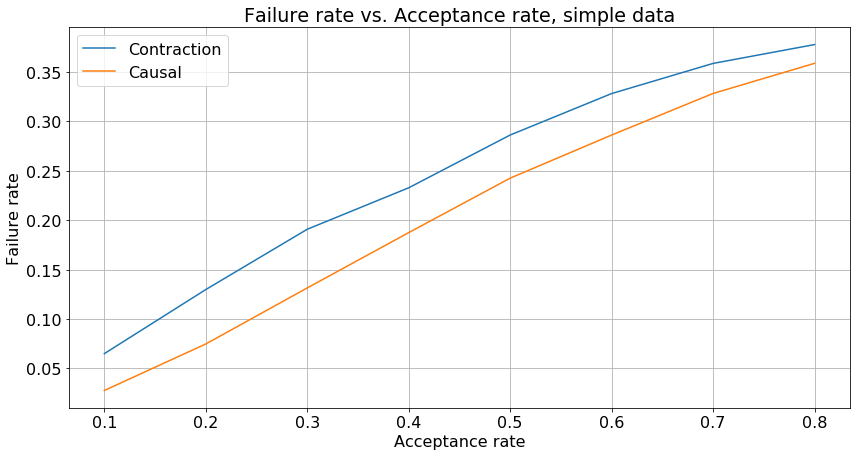

In [107]:
f_rates_cont = np.zeros(0)
#f_rates_caus = np.zeros(0)
x_vals = np.arange(1, 9) / 10

for r in range(1, 9):
    f_rates_cont = np.append(f_rates_cont,
        contraction(s_train_labeled, 'judgeID_J', 'decision_T', 'result_Y',
                    'probabilities_Y', 'acceptanceRate_R', r / 10))
    print(r)
    #f_rates_caus = np.append(f_rates_caus, 
    #                         np.mean((s_train.result_Y[s_train.decision_T==1] == 0) & (cdf(s_train.X[s_train.decision_T==1], logreg, 0) < r/10)))
    
plt.plot(x_vals, f_rates_cont, label="Contraction")
plt.plot(x_vals, f_rates_caus, label="Causal")
plt.title('Failure rate vs. Acceptance rate, simple data')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

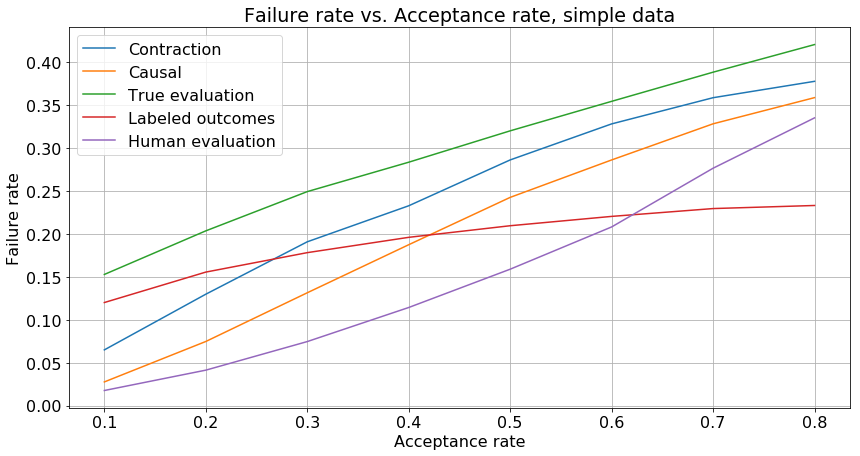

In [122]:
f_rates_true = np.zeros(0)
f_rates_labeled = np.zeros(0)
f_rates_human = np.zeros(0)

for r in range(1, 9):
    #### True evaluation
    # Sort by failure probabilities, subjects with the smallest risk are first. 
    s_sorted = s_test.sort_values(by='probabilities_Y', inplace=False, ascending=False)

    to_release = int(round(s_sorted.shape[0] * r / 10))

    # Calculate failure rate as the ratio of failures to successes among those 
    # who were given a positive decision, i.e. those whose probability of negative
    # outcome was low enough.
    f_rates_true = np.append(f_rates_true, np.mean(s_sorted.result_Y[0:to_release] == 0))
    
    #### Labeled outcomes only
    # Sort by failure probabilities, subjects with the smallest risk are first. 
    s_test_labeled.sort_values(by='probabilities_Y', inplace=True, ascending=False)
        
    to_release = int(round(s_test_labeled[s_test_labelead.decision_T==1].shape[0] * r / 10))

    f_rates_labeled = np.append(f_rates_labeled, np.mean(s_test_labeled.result_Y[0:to_release] == 0))
    
    #### Human error rate
    # Get judges with correct leniency as list
    correct_leniency_list = s_test_labeled.judgeID_J[
        s_test_labeled['acceptanceRate_R'].round(1) == r / 10].values

    # Released are the people they judged and released, T = 1
    released = s_test_labeled[s_test_labeled.judgeID_J.isin(correct_leniency_list)
                            & (s_test_labeled.decision_T == 1)]

    # Get their failure rate, aka ratio of reoffenders to number of people judged in total
    f_rates_human = np.append(f_rates_human, np.sum(
        released.result_Y == 0) / correct_leniency_list.shape[0])
    
plt.plot(x_vals, f_rates_cont, label="Contraction")
plt.plot(x_vals, f_rates_caus, label="Causal")
plt.plot(x_vals, f_rates_true, label="True evaluation")
plt.plot(x_vals, f_rates_labeled, label="Labeled outcomes")
plt.plot(x_vals, f_rates_human, label="Human evaluation")
plt.title('Failure rate vs. Acceptance rate, simple data')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()